In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [51]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [52]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

In [53]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 100

In [54]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [55]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 496 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 434 images belonging to 2 classes.


In [56]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=True,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = True

In [57]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
pretrained_model = mobilenet(inputs, training=False)


x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=200, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)

outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_6 (Dense)             (None, 200)               78854600  
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                           

In [58]:
EPOCHS = 25

def lr_schedule(EPOCHS):
    lr = 0.001
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True
        ),
        lr_callback
    ]
)

Epoch 1/25
2/2 [==============================] - 9s 5s/step - loss: 51.7126 - accuracy: 0.5444 - auc: 0.5089 - val_loss: 100.4873 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/25
2/2 [==============================] - 8s 3s/step - loss: 45.8032 - accuracy: 0.6855 - auc: 0.5000 - val_loss: 6.6200 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/25
2/2 [==============================] - 8s 3s/step - loss: 7.7198 - accuracy: 0.3427 - auc: 0.5222 - val_loss: 9.1979 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/25
2/2 [==============================] - 8s 5s/step - loss: 8.0826 - accuracy: 0.6855 - auc: 0.5032 - val_loss: 13.2956 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/25
2/2 [==============================] - 8s 5s/step - loss: 5.5872 - accuracy: 0.6875 - auc: 0.5143 - val_loss: 5.2362 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 6/25
2/2 [==============================] - 8s 3s/step - loss: 5.9835 - accurac

In [59]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int64))

cm = confusion_matrix(true_labels, pred_labels)

2/2 [==============================] - 5s 1s/step


In [60]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

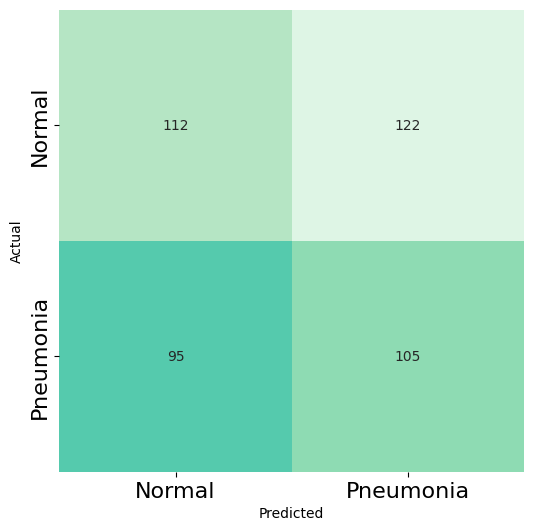

In [61]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [62]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [63]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [64]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.84
AUC: 0.93
Precision: 0.46
Recall: 0.53


In [65]:
cm

array([[112, 122],
       [ 95, 105]], dtype=int64)